In [2]:
# IMPORTS
import glob, os, sys, h5py
import numpy as np
sys.path.insert(0,'../../')
sys.path.insert(0,'/Library/TeX/texbin/')
sys.path.insert(0,'../../WaveformAnalysis')
sys.path.insert(0,'/home/tb829/project/purity-monitor/WaveformAnalysis/')
from scipy.signal import find_peaks, find_peaks_cwt, peak_widths, peak_prominences
from natsort import natsorted
from scipy.optimize import curve_fit
from multiprocessing import Pool, Manager

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 100

In [3]:
def rebin(hx,h,bins):
    bins = int(bins)
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

def gauss(x,a,mu,sigma): return (a*np.exp(-0.5*((x-mu)/sigma)**2))

def line(x,a,b): return a*(x-b)

In [4]:
def perm_run(p,x,y,min_peaks,max_error,trials):
    
    best_index = None
    lowest = 1000
    best = None
    
    bins = p[0]
    #bins = 30
    prominence = p[1]
    #prominence = 10
    distance = 500/bins
    try:
        x1, y1 = rebin(x,y,bins)

        pks, pdict = find_peaks(y1,prominence=prominence,distance=distance)
        if len(pks) < min_peaks: return
        plt.scatter([pks],[y1[pks]],20,'red','*')

        x2 = np.flip(x1)
        y2 = np.flip(y1)
        flat_end = np.argwhere(y2 > 2)[0][0]
        x2 = x2[flat_end:]
        y2 = y2[flat_end:]
        x1 = np.flip(x2)
        y1 = np.flip(y2)

        plt.plot(x1,y1)
        #plt.show()

        cumulative = 0

        counter = 0
        fitted = []

        for ii in np.arange(0,len(pks),1):
            tolerance = 0.2
            y_cut = y1
            ##print()
            while len(find_peaks(y_cut,prominence=prominence,distance=distance)[0]) > 1 and tolerance < 0.8:
                index = pks[ii]
                #peak_lx = pdict['left_bases'][ii]
                #peak_rx = pdict['right_bases'][ii]
                peak_lx, peak_rx = None, None
                try: peak_lx = int(index - np.argwhere(np.flip(y1[:index]) < tolerance*y1[index])[0][0]*1.1)
                except: peak_lx = pdict['left_bases'][ii]
                try: peak_rx = int((index + np.argwhere(y1[index:] < tolerance*y1[index])[0][0])*1.1)
                except: peak_rx = pdict['right_bases'][ii]
                x_cut = x1[int(peak_lx):peak_rx]
                y_cut = y1[int(peak_lx):peak_rx]
                ##print(f'{ii+1}/{len(pks)} L {peak_lx}, R: {peak_rx}')

                #plt.plot(x_cut,y_cut,color='magenta',lw=0.8)
                if len(find_peaks(y_cut,prominence=prominence)[0]) > 1:
                    ##print('Too many peaks in cut')
                    tolerance += 0.05
                    continue
                ##print(f'{ii+1}/{len(pks)} L {peak_lx}, R: {peak_rx}')
                ##print(peak_widths(y1,pks,rel_height=5)[0][ii])
            #plt.scatter(index,[y1[index]],20,'red','*')

            if np.abs(np.abs(index-peak_lx) - np.abs(peak_rx-index)) > np.abs(index-peak_lx)*0.2:
                peak_rx = index + np.abs(index-peak_lx)
                ##print(f'Fixing right base... -> L {peak_lx}, R: {peak_rx}')
                x_cut = x1[int(peak_lx):peak_rx]
                y_cut = y1[int(peak_lx):peak_rx]
                #plt.plot(x_cut,y_cut,color='blue',lw=0.8)

            sigma = np.abs(int(index - np.argwhere(np.flip(y1[:index]) < 0.5*y1[index])[0][0]))

            try:popt, pcov = curve_fit(gauss,x_cut,y_cut,p0=[y1[index],np.abs(index-peak_lx),sigma],maxfev=10000000)
            except Exception as e:
                #print(e)
                continue
            perr = np.sqrt(np.diag(pcov))[1]
            ##print(perr)
            if np.sqrt(np.diag(pcov))[1] > max_error:
                #plt.show()
                continue
            counter += 1
            fitted.append(pks[ii])
            perr = np.sqrt(np.diag(pcov))[1]
            #plt.plot(x_cut,gauss(x_cut,*popt),color='lime')
            #plt.show()
            cumulative += perr

        if counter < min_peaks: return

        lowest2 = 1000
        index = 0
        popt, pcov, perr = None, None, None

        for ii in np.arange(0,len(fitted)-(min_peaks-1)):
            peaks = fitted[ii:ii+min_peaks]
            perrs = fitted[ii:ii+min_peaks]
            try: popt,pcov = curve_fit(line,np.arange(1,(min_peaks+1)),peaks,maxfev=100000)
            except: continue
            perr = np.sqrt(np.diag(pcov))[1]
            #print(ii, ' ', popt,' ', perr)
            if perr < lowest:
                lowest2 = perr
                index = ii

        if lowest2 == 1000 or popt is None: return
        else:
            #final_gains.append(popt[0])
            #final_gains_perms.append(p)
            #final_gain_errs.append(perr)
            #final_peaks_start.append(index)
            if perr < lowest:
                lowest = perr
                best = p
                best_index = index
                
            trials[p] = (popt[0],perr,best_index)

        #plt.clf()
        #plt.plot(x1,y1)
        for ftd in fitted:
            pass#plt.scatter([pks[ftd]],[y1[pks[ftd]]],20,'green','*')

        ##print(p,end=' -> ')
        ##print(cumulative)

    except Exception as e:
        #print(e)
        return
        
    #plt.show()
    #print(best)

30.0  @  5.0


IntProgress(value=0, bar_style='info', description='Loading MCA perms...', layout=Layout(width='100%'), max=10…

33.4  @  5.0


IntProgress(value=0, bar_style='info', description='Loading MCA perms...', layout=Layout(width='100%'), max=10…

KeyboardInterrupt: 

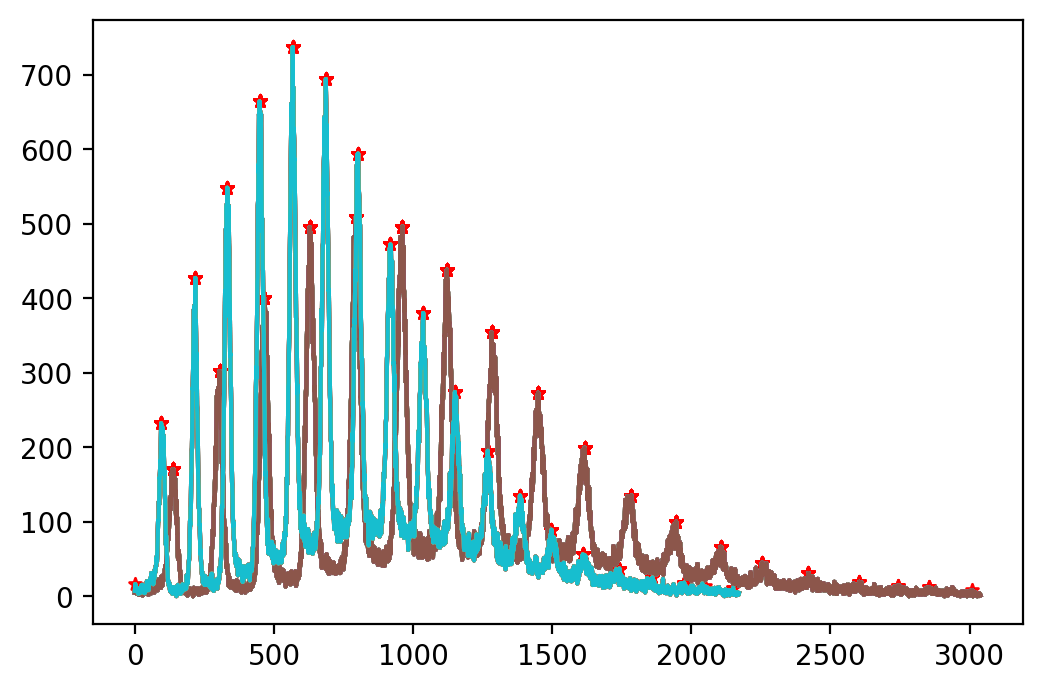

In [7]:
#FILE = r'/Users/tizi/Documents/YALE_WL.nosync/data/20220812/4Vpp/0.5kHz/mca_keith_30.00OV_0.h5'
#FILE = r'/Users/tizi/Documents/YALE_WL.nosync/data/20220810/4.0Vpp/0.5kHz/mca_keith_30.00OV_0.h5'

gains = []
sigmas = []
volts = []
frequencies = []

files = glob.glob(r'/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_3min_0.2V_intervals/**/*')
files = glob.glob(r'/Users/tizi/Documents/YALE_WL.nosync/data/20220812/4Vpp_3min_0.2V_intervals/**/*')
for file in files:
    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys(): 
        df = np.array(ch2.get(key))
    h = df
    hx = np.arange(0,len(h),1)
    x,y = hx, h
    pind, pdict = find_peaks(y, prominence=2000)
    plt.rcParams['figure.dpi']= 200

    voltage = file.split('_')[-2]
    voltage = float(voltage.split('OV')[0])

    frequency = float(file.split('/')[-2].split('kHz')[0])
    print(voltage,' @ ',frequency)

    plt.plot(x,y)

    rix_ind = 0
    lix_ind = 0
    rix_ind_ar = x[int(pind):][y[int(pind):] <= pdict['right_bases']]
    if len(rix_ind_ar) == 0: rix_ind = (len(x)-1)
    else: rix_ind = rix_ind_ar[0]
    lix_ind_ar = x[:int(pind)][y[:int(pind)] <= pdict['left_bases']]
    if len(lix_ind_ar) == 0: lix_ind = 0
    else: lix_ind = lix_ind_ar[0]

    #plt.vlines(np.asarray([pind,lix_ind,rix_ind]),0,pdict['prominences'].max(),colors=['red'])
    #plt.vlines(np.asarray([pdict['left_bases'],pdict['right_bases']]),0,pdict['prominences'].max(),colors=['blue'])
    #plt.xlim(lix_ind-10,rix_ind+300)
    plt.clf()
    x = x[int(pdict['right_bases']):]
    y = y[int(pdict['right_bases']):]
    plt.plot(x,y)
    plt.clf()

    x1, y1 = rebin(x,y,100)
    plt.plot(x1,y1)
    plt.clf()
    from timeit import repeat
    from ipywidgets import IntProgress
    from IPython.display import display
    import itertools

    bin_start = 5
    bin_stop = 50
    bin_step = 2 #  DO NOT SET THIS TO FLOAT VALUES --> REBIN ONLY TAKES INTS AND CONVERTS TO INT ANYWAY!!!!!!

    prominence_start = 8
    prominence_stop = 100
    prominence_step = 2

    distance_start = 5
    distance_stop = 50
    distance_step = 2
    #1250/bins

    min_peaks = 5
    max_error = 1.5

    perms = [item for item in itertools.product(np.arange(bin_start, bin_stop,bin_step),np.arange(prominence_start, prominence_stop,prominence_step))]

    #print(len(perms))
    lowest = 300
    best = None
    final_gains_perms = []
    final_gains = []
    final_gain_errs = []
    final_peaks_start = []
    best_index = None

    f = IntProgress(value=0,min=0,max=len(perms),step=1,description='Loading MCA perms...',bar_style='info',layout={"width": "100%"})
    display(f)
    
    trials = {}

    for perm in perms:
        f.value += 1
        perm_run(perm,x,y,min_peaks,max_error,trials)

    #print(trials)
    lowest_err = 10000
    best_p = None
    
    for p in trials.keys():
        gain, perr, best_index = trials[p]
        if perr < lowest_err:
            best_p = p
            lowest_err = perr
    
    best = best_p
    best_index = trials[best][2]
"""print(best)
print(best_index)
print(final_gains)
print(final_gain_errs)
print(final_peaks_start)"""

final_peaks = []
final_perrs = []

if best is None: print('Method failed')
else:
    bins = best[0]
    prominence = best[1]
    distance = 500/bins
    x1, y1 = rebin(x,y,bins)

    pks, pdict = find_peaks(y1,prominence=prominence,distance=distance)

    x2 = np.flip(x1)
    y2 = np.flip(y1)
    flat_end = np.argwhere(y2 > 2)[0][0]
    x2 = x2[flat_end:]
    y2 = y2[flat_end:]
    x1 = np.flip(x2)
    y1 = np.flip(y2)
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(x1,y1)
    fitted = []
    for ii in np.arange(0,len(pks),1):
        tolerance = 0.2
        y_cut = y1
        ##print()
        while len(find_peaks(y_cut,prominence=prominence,distance=distance)[0]) > 1 and tolerance < 0.8:
            index = pks[ii]
            #peak_lx = pdict['left_bases'][ii]
            #peak_rx = pdict['right_bases'][ii]
            peak_lx, peak_rx = None, None
            try: peak_lx = int(index - np.argwhere(np.flip(y1[:index]) < tolerance*y1[index])[0][0]*1.1)
            except: peak_lx = pdict['left_bases'][ii]
            try: peak_rx = int((index + np.argwhere(y1[index:] < tolerance*y1[index])[0][0])*1.1)
            except: peak_rx = pdict['right_bases'][ii]
            x_cut = x1[int(peak_lx):peak_rx]
            y_cut = y1[int(peak_lx):peak_rx]
            ##print(f'{ii+1}/{len(pks)} L {peak_lx}, R: {peak_rx}')

            #plt.plot(x_cut,y_cut,color='magenta',lw=0.8)
            if len(find_peaks(y_cut,prominence=prominence)[0]) > 1:
                ##print('Too many peaks in cut')
                tolerance += 0.05
                continue
            ##print(f'{ii+1}/{len(pks)} L {peak_lx}, R: {peak_rx}')
            ##print(peak_widths(y1,pks,rel_height=5)[0][ii])

        if np.abs(np.abs(index-peak_lx) - np.abs(peak_rx-index)) > np.abs(index-peak_lx)*0.2:
            peak_rx = index + np.abs(index-peak_lx)
            #print(f'Fixing right base... -> L {peak_lx}, R: {peak_rx}')
            x_cut = x1[int(peak_lx):peak_rx]
            y_cut = y1[int(peak_lx):peak_rx]
            #plt.plot(x_cut,y_cut,color='blue',lw=0.8)

        try:sigma = np.abs(int(index - np.argwhere(np.flip(y1[:index]) < 0.5*y1[index])[0][0]))
        except: sigma = np.abs(index-peak_lx)*0.5

        try:popt, pcov = curve_fit(gauss,x_cut,y_cut,p0=[y1[index],np.abs(index-peak_lx),sigma],maxfev=10000000)
        except Exception as e:
            #print(e)
            continue
        perr = np.sqrt(np.diag(pcov))[1]
        #print(popt,' ',perr)
        final_peaks.append(popt[1])
        final_perrs.append(perr)
        if np.sqrt(np.diag(pcov))[1] > max_error:
            #plt.show()
            continue
        #counter += 1
        fitted.append(ii)
        perr = np.sqrt(np.diag(pcov))[1]
        plt.plot(x_cut,gauss(x_cut,*popt),color='lime')
        #plt.show()
    for ftd in fitted:
        plt.scatter([pks[ftd]],[y1[pks[ftd]]],30,'red','*')

    distances = []
    sorted_peaks = np.sort(pks)
    for i in np.arange(2,len(sorted_peaks),1):
        #prev = np.abs(sorted_peaks[i-1]-sorted_peaks[i-2])
        #curr = np.abs(sorted_peaks[i]-sorted_peaks[i-1])
        distances.append(np.abs(sorted_peaks[i]-sorted_peaks[i-1]))
    #print(distances)

    #plt.vlines([peak_lx,peak_rx,index],0,y1[index],colors=['red'],linestyles='dashed')
    plt.plot(x1[peak_lx:peak_rx],gauss(x1[peak_lx:peak_rx],*popt),color='lime')
    plt.vlines(fitted,0,50,colors=['blue'],linestyles='dotted')
    #plt.xlim(0,250)
    #plt.show()
    #print(final_peaks)
    #print(final_perrs)
    #print(best)

    #x3, y3 = rebin(x,y,best[0])
    plt.xlim(0,len(h)/best[0])
    plt.subplot(1,2,2)

    ii = best_index
    peaks = final_peaks[ii:ii+min_peaks]
    perrs = final_perrs[ii:ii+min_peaks]
    popt,pcov = None, None
    try: popt,pcov = curve_fit(line,np.arange(1,(min_peaks+1)),peaks,maxfev=100000)
    except: pass
    perr = np.sqrt(np.diag(pcov))[1]
    print(ii, ' ', popt,' ', perr)

    print(f'Best peaks are peaks {ii} to {ii+(min_peaks-1)}')

    peaks = np.asarray(final_peaks[ii:ii+min_peaks])*best[0]
    perrs = np.asarray(final_perrs[ii:ii+min_peaks])*best[0]
    try: popt,pcov = curve_fit(line,np.arange(1,(min_peaks+1)),peaks,maxfev=100000)
    except: pass
    plt.plot(np.arange(1,(min_peaks+1)),line(np.arange(1,(min_peaks+1)),*popt))
    #plt.scatter(np.arange(1,5),peaks,10)
    plt.errorbar(np.arange(1,(min_peaks+1)),peaks,yerr=perrs,fmt='o',ms=7,)
    plt.show()

    gains.append(popt[0])
    sigmas.append(np.sqrt(np.diag(pcov))[1]*best[0])
    volts.append(voltage)
    frequencies.append(frequency)
    print(f'Gain {popt[0]} and sigma {np.sqrt(np.diag(pcov))[1]} for {file}')

In [ ]:
for ii, voltage in enumerate(volts):
    print(f'- {voltage:.02f}V @ {frequencies[ii]:.01f}kHz -> Gain {gains[ii]} +/- {sigmas[ii]}')

In [ ]:
to_plot_inds = []
to_plot_vals = []
for ind in np.arange(0,len(volts)):
    to_plot_inds.append(str(volts[ind])+str('@')+str(frequencies[ind]))
    to_plot_vals.append((gains[ind],sigmas[ind]))
uniqe_freq = np.unique(frequencies)
unique_volts = np.unique(volts)
print(to_plot_inds)

colors = ['blue', 'green', 'red', 'orange', 'magenta', 'skyblue', 'brown']
next_color = colors[0]
for uf in uniqe_freq:
    line_vals = []
    err_vals = []
    volt_vals = []
    for uv in unique_volts:
        key = str(uv)+str('@')+str(uf)
        print(key)
        try:index = np.argwhere(np.asarray(to_plot_inds) == key)[0][0]
        except: continue
        gain, sigma = to_plot_vals[index]
        plt.scatter([uv], [gain],20,color=next_color)
        line_vals.append(gain)
        err_vals.append(sigma)
        volt_vals.append(uv)

    try:popt,pcov = curve_fit(line,volt_vals,line_vals)
    except: continue
    plt.plot(volt_vals,line(volt_vals,*popt),label=uf,color=next_color)
    next_color = colors[np.argwhere(np.asarray(colors) == next_color)[0][0]+1]
plt.legend(loc='lower right')
plt.ylim(400,1300)
plt.show()